# Objectives

- Experiment with generating and applying foreground masks
- Pick parameters for foreground masks

# Contents

Step-by-step walk-through of the process of choosing valid regions in images with aberrations
1. creating a mask
2. getting the binarized image with dirt
3. applying the mask to identify the dirty area in valid region

Testing these parameters on all images with aberrations (command+F "Test these parameters on all images"), showing for each image:
- image_cropped
- valid_region
- dirt_in_valid_region

In [7]:
from skimage.io import imread, imsave
from skimage.util import img_as_float
from skimage.filters import difference_of_gaussians, threshold_otsu
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math, os, skimage, warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

In [140]:
cropx, cropy = 1448, 1448
sig_min = 1
sig_max1 = 12
sig_max2 = 3

base_dir = '2022-04-27_GB20106_backgrounds_processed'
cols = ['image_name',
        'run_no',
        'lane_no',
        'binarization_threshold',
        'sum_bin_filtered2']

# params for producing mask
grow_factor = 0.0375
bright_thresh = 14000
size_thresh = 3e-3 # was 3e-4
grow_cycles = 1

# params for getting image with dirt
binarization_threshold = 0.05

# 1. Create a mask

In [134]:
path = '/Users/jenny.vophamhi/Desktop\
/biohub/dirtiness/2022-04-27_GB20106_backgrounds_processed\
/20220413-155750/background-20220413-155750-0.tif'

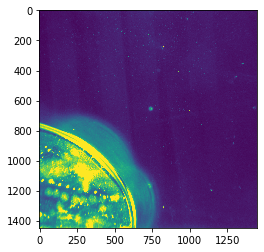

In [135]:
# load and crop image
image = imread(path)
image_cropped = crop_center(image,cropx,cropy)

plt.imshow(image_cropped)

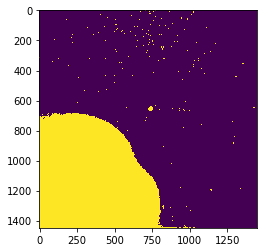

In [141]:
# Select bright features
feature_mask = image_cropped > bright_thresh
labeled = skimage.measure.label(feature_mask)

plt.imshow(feature_mask)

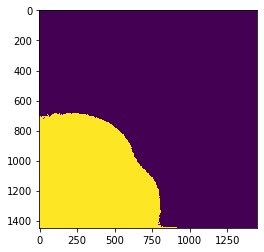

In [142]:
# Exclude small regions
for props in skimage.measure.regionprops(labeled):
    if props.area < labeled.size * size_thresh:
        feature_mask[labeled == props.label] = 0
        
plt.imshow(feature_mask)

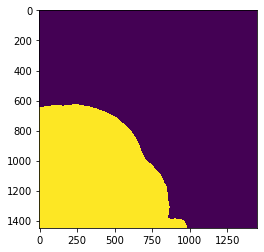

In [143]:
# Grow
grow_px = image_cropped.shape[0] * grow_factor
for i in range(grow_cycles):
    feature_mask = skimage.segmentation.expand_labels(feature_mask,
                                                      grow_px)
plt.imshow(feature_mask)

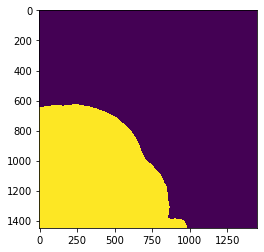

In [144]:
# Fill in hollow regions
labeled = skimage.measure.label(~feature_mask)
propses = skimage.measure.regionprops(labeled)
areas = [(props.area, props.label) for props in propses]
areas.sort()
areas.pop()
for area, label in areas:
    feature_mask[labeled == label] = 1

# Also mask out undefined areas due to image alignment
feature_mask[np.isnan(image_cropped)] = 1

plt.imshow(feature_mask)

# 2. Get binarized image with dirt

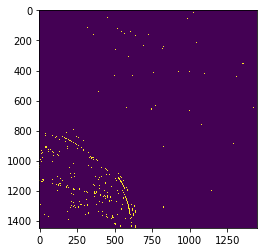

In [145]:
filtered1_image = difference_of_gaussians(image_cropped, sig_min, sig_max1)
filtered2_image = difference_of_gaussians(filtered1_image, sig_min, sig_max2)
filtered2_image[filtered2_image < 0.] = 0.
filtered2_binary = filtered2_image > binarization_threshold

plt.imshow(filtered2_binary)

# 3. Apply mask to identify dirty area in valid region

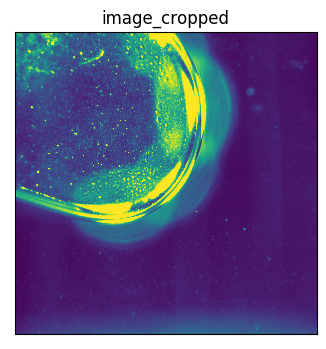

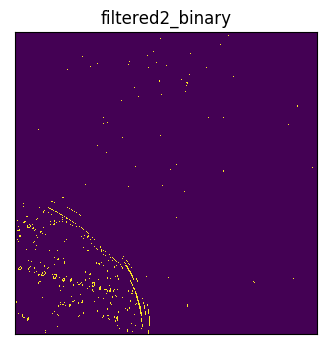

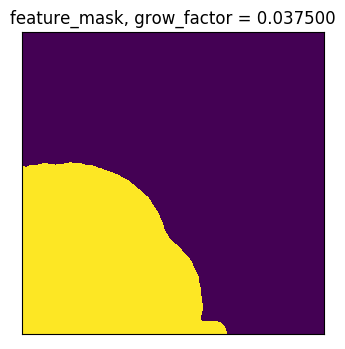

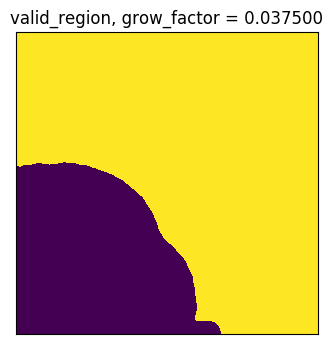

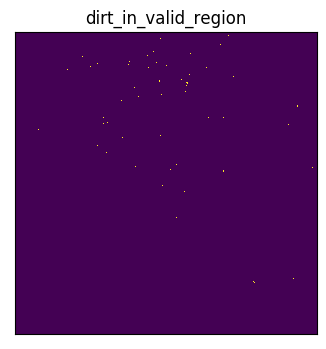

In [154]:
valid_region = np.logical_not(feature_mask)
dirty_area_in_valid_region = np.logical_and(filtered2_binary, valid_region)

plt.figure(dpi=100)
plt.title('image_cropped')
plt.imshow(image_cropped)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(dpi=100)
plt.title('filtered2_binary')
plt.imshow(filtered2_binary)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(dpi=100)
plt.title('feature_mask, grow_factor = %f' % grow_factor)
plt.imshow(feature_mask)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(dpi=100)
plt.title('valid_region, grow_factor = %f' % grow_factor)
plt.imshow(valid_region)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(dpi=100)
plt.title('dirt_in_valid_region')
plt.imshow(dirty_area_in_valid_region)
plt.xticks([])
plt.yticks([])
plt.show()

# Test these parameters on all images with aberrations

In [155]:
def do_test(path):
    # Load and crop image
    image = imread(path)
    image_cropped = crop_center(image,cropx,cropy)

    # Select bright features
    feature_mask = image_cropped > bright_thresh
    labeled = skimage.measure.label(feature_mask)

    # Exclude small regions
    for props in skimage.measure.regionprops(labeled):
        if props.area < labeled.size * size_thresh:
            feature_mask[labeled == props.label] = 0

    # Grow
    grow_px = image_cropped.shape[0] * grow_factor
    for i in range(grow_cycles):
        feature_mask = skimage.segmentation.expand_labels(feature_mask,
                                                          grow_px)

    # Fill in hollow regions
    labeled = skimage.measure.label(~feature_mask)
    propses = skimage.measure.regionprops(labeled)
    areas = [(props.area, props.label) for props in propses]
    areas.sort()
    areas.pop()
    for area, label in areas:
        feature_mask[labeled == label] = 1

    # Also mask out undefined areas due to image alignment
    feature_mask[np.isnan(image_cropped)] = 1

    # Get binarized image with dirt
    filtered1_image = difference_of_gaussians(image_cropped, sig_min, sig_max1)
    filtered2_image = difference_of_gaussians(filtered1_image, sig_min, sig_max2)
    filtered2_image[filtered2_image < 0.] = 0.
    filtered2_binary = filtered2_image > binarization_threshold

    # Apply mask to identify dirty area in valid region
    valid_region = np.logical_not(feature_mask)
    dirty_area_in_valid_region = np.logical_and(filtered2_binary, valid_region)

    plt.figure(dpi=100)
    plt.title('image_cropped')
    plt.imshow(image_cropped)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    plt.figure(dpi=100)
    plt.title('valid_region, grow_factor = %f' % grow_factor)
    plt.imshow(valid_region)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    plt.figure(dpi=100)
    plt.title('dirt_in_valid_region')
    plt.imshow(dirty_area_in_valid_region)
    plt.xticks([])
    plt.yticks([])
    plt.show()                                       

In [147]:
base_dir = '2022-04-27_GB20106_backgrounds_processed'

In [148]:
run_dirs = sorted(os.listdir(base_dir))
if '.DS_Store' in run_dirs:
    run_dirs.remove('.DS_Store')

In [149]:
aberr_image_names = [ 'background-20220413-155750-0.tif',
                'background-20220218-152118-2.tif',
                'background-20220208-162426-4.tif',
                'background-20220301-181652-4.tif',
                'background-20220418-152413-5.tif',
                'background-20220114-143015-6.tif',
                'background-20220114-162658-6.tif',
                'background-20220301-181652-6.tif',
                'background-20220413-155750-6.tif',
                'background-20220127-141305-7.tif',
                'background-20220222-172341-7.tif',
                'background-20220301-181652-7.tif',
                'background-20220316-141612-7.tif']

background-20220114-143015-6.tif


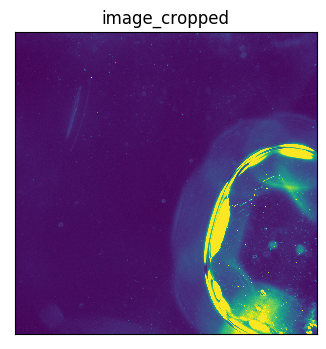

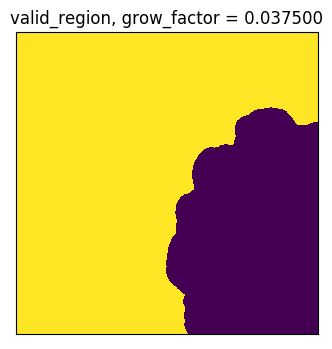

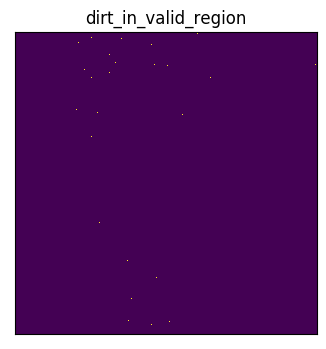

background-20220114-162658-6.tif


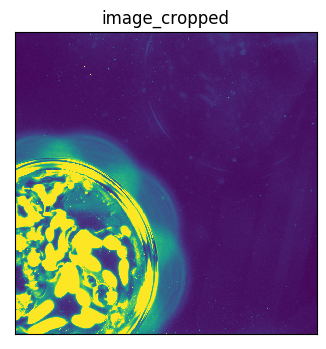

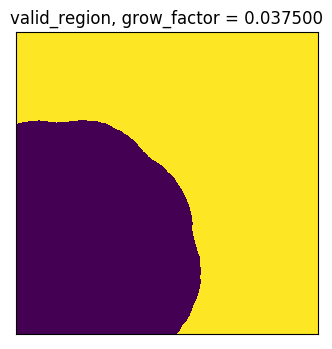

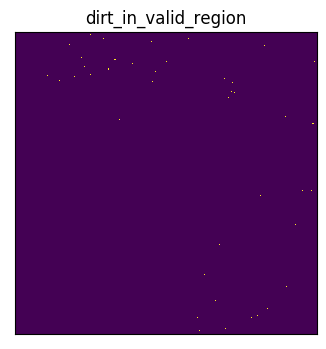

background-20220127-141305-7.tif


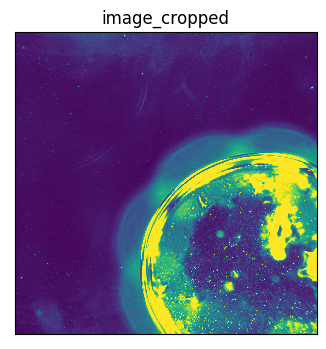

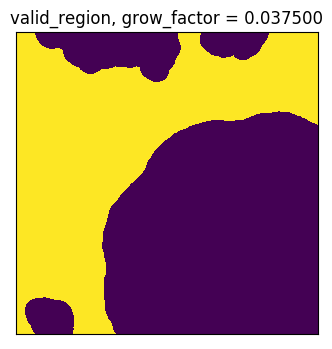

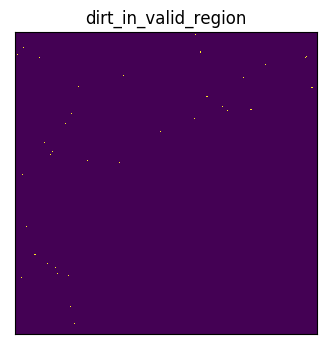

background-20220208-162426-4.tif


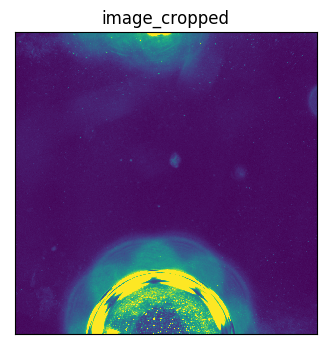

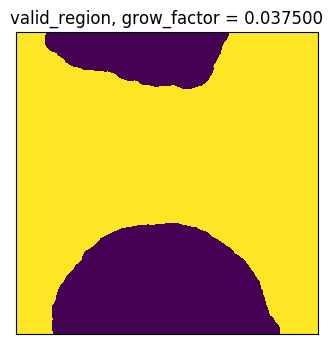

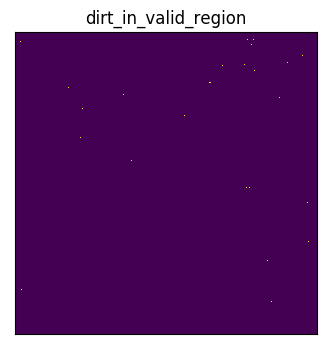

background-20220218-152118-2.tif


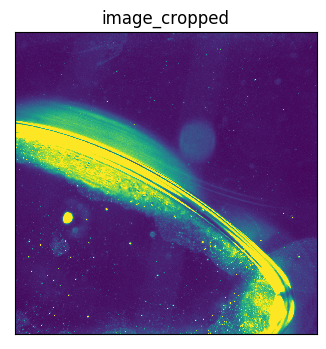

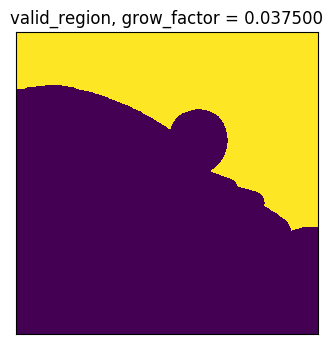

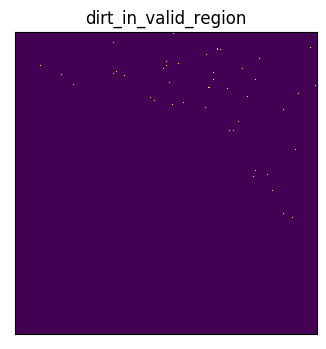

background-20220222-172341-7.tif


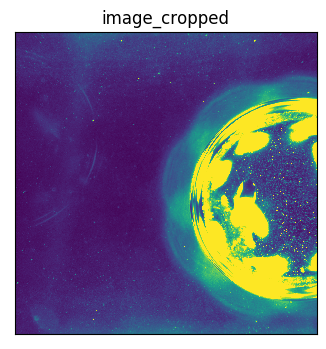

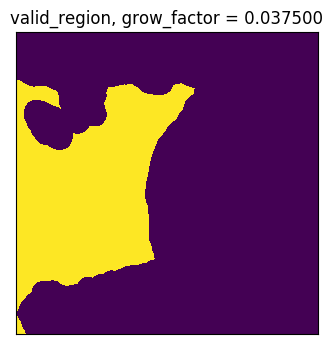

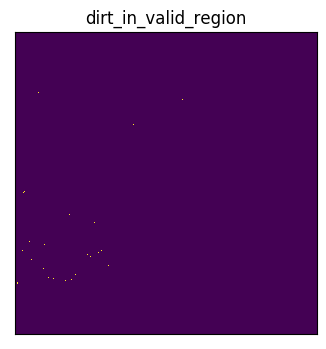

background-20220301-181652-4.tif


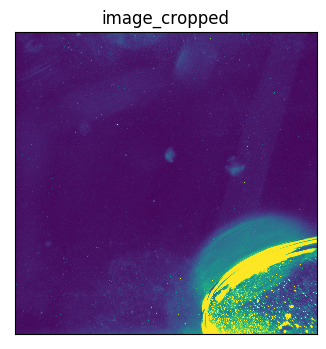

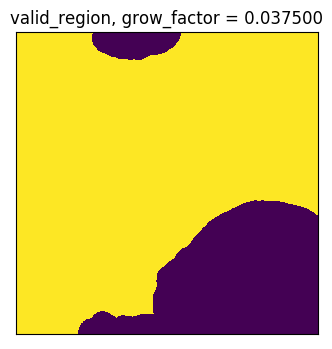

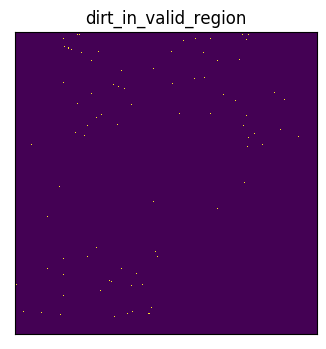

background-20220301-181652-6.tif


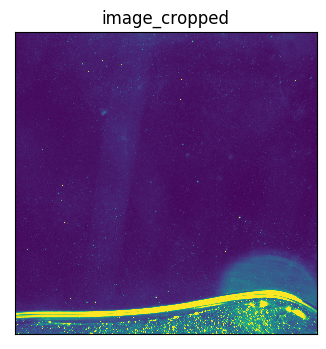

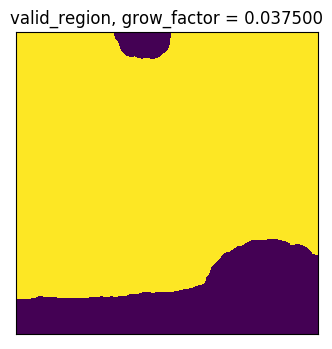

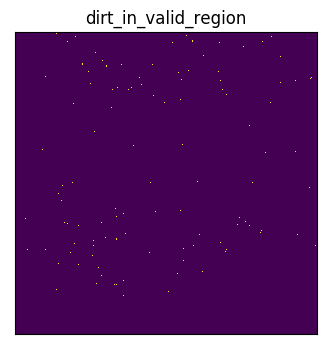

background-20220301-181652-7.tif


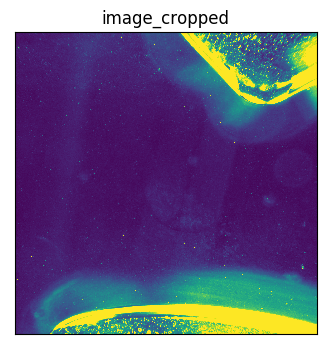

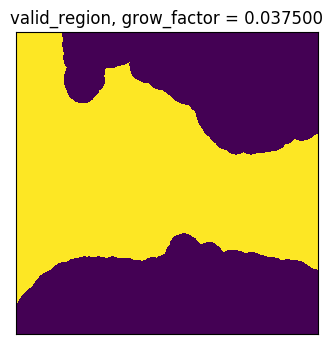

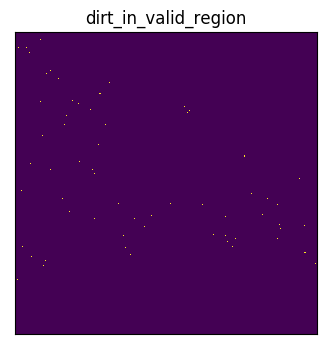

background-20220316-141612-7.tif


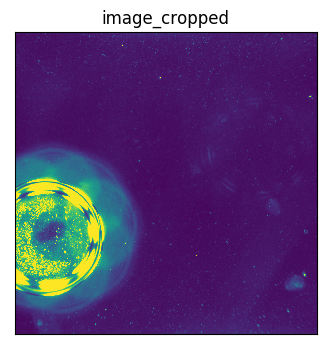

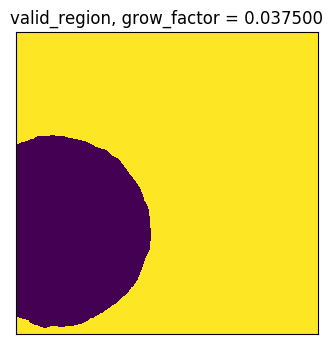

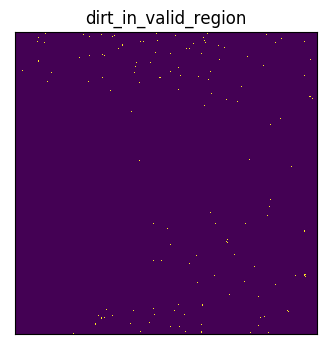

background-20220413-155750-0.tif


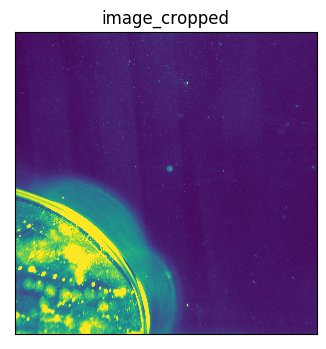

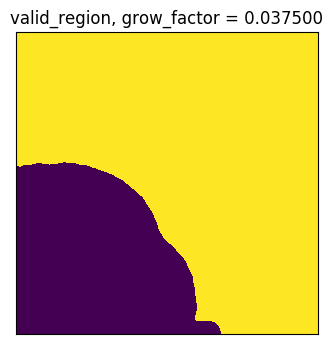

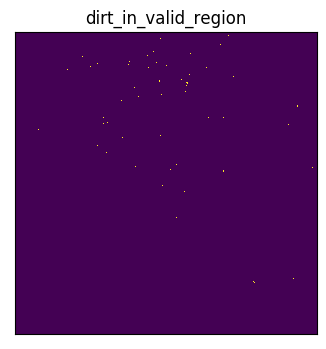

background-20220413-155750-6.tif


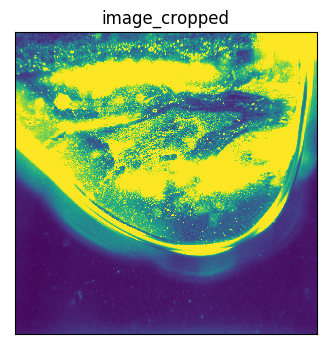

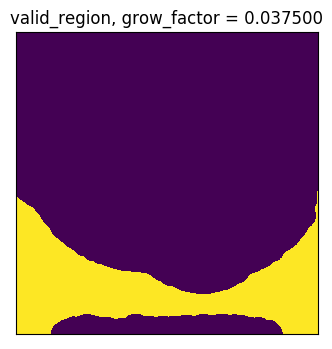

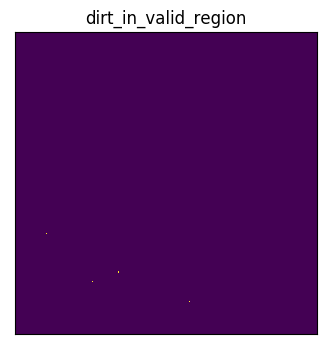

background-20220418-152413-5.tif


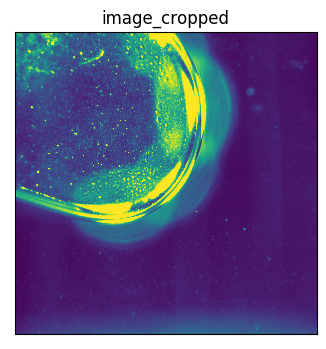

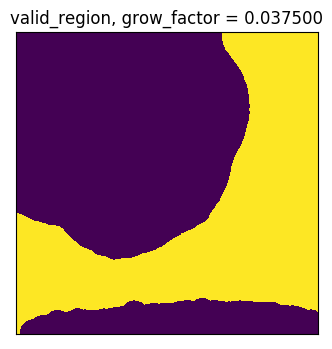

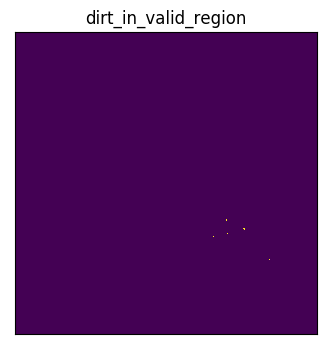

In [156]:
for i, run_dir in enumerate(run_dirs):
#     print(run_dir, '\t%d/%d' % (i, len(run_dirs)))
    data_dir = '%s/%s' % (base_dir, run_dir)
    image_names = sorted(os.listdir(data_dir))
    for image_name in image_names:
        
        if image_name[-6]!='-':
            continue
        if image_name not in aberr_image_names:
            continue
            
        print('=============================================')
        print(image_name)
        print('=============================================')
        
        lane_no = int(image_name.rsplit(".", 1)[0].rsplit("-", 1)[-1])
        path = '%s/%s' % (data_dir, image_name)
        
        do_test(path)
        